In [1]:
# Import python modules 

import robustocs as rocs # Robust optimal contribution selection (unertainty in optimal contribution selectio)
from robustocs import utils
from robustocs import pedigree
import math
import itertools
from tabulate import tabulate

import numpy as np # used for numerical computing
import pandas as pd # used for data manipulation and analysis



import sklearn # used libraries for machine learning in Python
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats


import matplotlib.pyplot as plt # plotting library
import seaborn as sns


In [2]:
import os # a way to interact with the operating system
cwd = os.getcwd()
cwd

'/Users/s2745345/Documents/jortiz_phd/robust/robust_lambda/robustOCS'

# Kappa
- In robust optimal contribution selection, "Kappa" is  a term thet control how resilient the solution must be to variation in expected breeding values. Kappa can take values >- 0. Higher value represent a higher tolerance for uncertainty. Taking k = 0 corresponds to assumming miu is known exactly. 

- From a probabilistic point of view, k represents the size of uncertainty set and it corresponds to the quantile yielded by the inverse cumulative distribution function. 

- Calibration of k are three major challenges one encounters when trying to implement robust portfolio optimization in practice. 

- Leveraging k is a parameter in the obective function, we derived its upper bound and prpose a rule of thumb for its calibration in terms of Sharpe ratios (?). 

 - Quadratic uncertainty set approach, one can define the expected returns that deciate most negatively from the estimated retunrs within a certain level of uncertainty.

In [3]:
# load in the problem variables
sigma, mubar, omega, n, sires, dams, names = rocs.load_problem(
    sigma_filename="50/A50.txt",
    mu_filename="50/EBV50.txt",
    omega_filename="50/S50.txt",
    sex_filename="50/SEX50.txt",
    issparse=True
)

sires = range(0, n, 2)
dams = range(1, n, 2)

In [ ]:
# Max contributions definitions
upper = np.zeros(n)
upper[::2] = 0.5  
print(upper)
upper[1::2] = 0.02 
print(upper)

[0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.
 0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.
 0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0.  0.5 0. ]
[0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02
 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02
 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02
 0.5  0.02 0.5  0.02 0.5  0.02 0.5  0.02]


In [5]:
# Calculating OCS fixing lambda and changing kappa

values_kappa = (0.0, 0.5, 1.0, 1.5, 2.0)

results = []
contributions = []

# upper
upper = np.zeros(n)
upper[::2] = 0.5  
upper[1::2] = 0.02 

# lower
lower = np.zeros(n)
lower[::2] = 0.0  
lower[1::2] = 0.02  

kin = sigma/2

lam = 1

n = kin.shape[0]
#print(n)
w = np.ones(n) / n
#print(sum(w))
#print(w)
genetic_merit_current = utils.expected_genetic_merit(w, mubar)
group_coancestry_current = utils.group_coancestry(w, kin)
#print(genetic_merit_current)
print(group_coancestry_current)

# Run the function for each lambda value
for k in values_kappa:
    # Get the result from the previous function call
    w, z, obj = rocs.highs_robust_genetics(sigma, mubar, omega, sires, dams, lam=lam, kappa=k, dimension=n, upper_bound=upper, lower_bound=lower)
    
    # Compute the expected genetic merit and group coancestry
    genetic_merit_sel = utils.expected_genetic_merit(w, mubar)
    group_coancestry_sel = utils.group_coancestry(w, kin)
    group_uncertainty = math.sqrt(w.transpose()@omega@w)
    deltaC = (group_coancestry_sel - group_coancestry_current) / (1.0 - group_coancestry_current)
    Ne = 1 / (2 * deltaC)
    
    # Append results and contributions
    results.append((k, lam, obj, z, genetic_merit_sel, group_coancestry_sel, group_uncertainty, deltaC, Ne))
    contributions.append((w))


# Convert results to a pandas DataFrame for a table-like structure
df_kappa = pd.DataFrame(results, columns=['kappa','lambda', 'objective', 'z', 'genetic_merit_sel', 'group_coancestry_sel', 'group_uncertainty','deltaC', 'Ne'])
df_contributions = pd.DataFrame(np.array(contributions).T, columns=['kappa0', 'kappa0.5', 'kappa1', 'kappa1.5', 'kappa2'])

# Optionally, print the table
#filtered_df = df[(df["deltaC"] > 0.0049) & (df["deltaC"] < 0.015)]


0.043716072082519535
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms


In [6]:
# Select the required columns
df_selected = df_kappa[['kappa', 'objective', 'genetic_merit_sel', 'group_coancestry_sel', 'group_uncertainty']]

# Round the values to 2 decimal places
df_rounded = df_selected.round(2)

# Print using tabulate
print(tabulate(df_rounded, headers='keys', tablefmt='psql'))

+----+---------+-------------+---------------------+------------------------+---------------------+
|    |   kappa |   objective |   genetic_merit_sel |   group_coancestry_sel |   group_uncertainty |
|----+---------+-------------+---------------------+------------------------+---------------------|
|  0 |     0   |        1.95 |                2.03 |                   0.07 |                0.14 |
|  1 |     0.5 |        1.88 |                2.02 |                   0.07 |                0.13 |
|  2 |     1   |        1.82 |                2.01 |                   0.06 |                0.13 |
|  3 |     1.5 |        1.76 |                2    |                   0.06 |                0.12 |
|  4 |     2   |        1.7  |                1.99 |                   0.06 |                0.12 |
+----+---------+-------------+---------------------+------------------------+---------------------+


1) group coancestry and group uncertainty seem to be correlated2
2) group coancestry and delta G seem to be correlated, see relationship between them 
3) lower uncertainty Ne (diversity increase) - Kinhorn
4) table kappa, objective, delta G, group coancestry, sqr group uncertainty (Josh' paper)
5) What else what should we looking ??
6) Resultados prelimares sugieren que en una generacion, incluir uncertainty no afecta numericamente el valor genetico y el parentezco entre los animales seleccionados como futuros padres, esto es importante porque uncertainty no me double penalize genetic merit.
7) Preliminary results show that consider the conditional variance of the estimated breeding values does not huge numerical changes can be seen the genetic value and group coancestry of selected parents. As expected group uncertainty decresase as kappa decrease
8) como serian los resultado si solo incluyo diagonal y no toda omega ?????
9) Shinkage estimation

In [25]:
# Define kappa and lambda values
values_kappa = [0.0, 0.5, 1.0, 5.0, 10.0, 15.0]
values_lambda = [1, 2, 3, 4, 5, 6, 7, 8]

# Initialize lists to store results
results = []
contributions = []

# Get dimensions from kinship matrix
n = sigma.shape[0]

# Upper and Lower Bounds
upper = np.zeros(n)
upper[::2] = 0.5  
upper[1::2] = 0.02 

lower = np.zeros(n)
lower[::2] = 0.0  
lower[1::2] = 0.02  

# Compute kinship factor
kin = sigma / 2

# Initialize equal selection weights
w = np.ones(n) / n

# Compute current genetic merit and coancestry
genetic_merit_sel = utils.expected_genetic_merit(w, mubar)
group_coancestry_sel = utils.group_coancestry(w, kin)
group_uncertainty = math.sqrt(w.transpose()@omega@w)
deltaC = (group_coancestry_sel - group_coancestry_current) / (1.0 - group_coancestry_current)
Ne = 1 / (2 * deltaC)

# Loop over all kappa and lambda values
for k in values_kappa:
    for l in values_lambda:
        # Run the optimization function for each (kappa, lambda) combination
        w, z, obj = rocs.highs_robust_genetics(sigma, mubar, omega, sires, dams, lam=l, kappa=k, dimension=n, upper_bound=upper, lower_bound=lower)
        
        # Compute genetic merit and coancestry after selection
        genetic_merit_sel = utils.expected_genetic_merit(w, mubar)
        group_coancestry_sel = utils.group_coancestry(w, kin)

        # Compute changes in coancestry and effective population size (Ne)
        deltaC = (group_coancestry_sel - group_coancestry_current) / (1.0 - group_coancestry_current)
        Ne = 1 / (2 * deltaC) if deltaC != 0 else np.inf  # Avoid division by zero

        # Store results
        results.append((k, l, obj, z, genetic_merit_sel, group_coancestry_sel, deltaC, Ne))
        contributions.append(w)

# Convert results into a DataFrame for easy analysis
df_kappa = pd.DataFrame(results, columns=['k', 'l', 'obj', 'z', 'genetic_merit_sel', 'group_coancestry_sel', 'deltaC', 'Ne'])

# Select the required columns
df_selected = df_kappa[['k','l', 'z', 'group_coancestry_sel']]

# Round the values to 2 decimal places
df_rounded = df_selected.round(2)

# Print using tabulate
print(tabulate(df_rounded, headers='keys', tablefmt='psql'))

/var/folders/yh/0bk27b457hb862b_2wsrctcr0000gr/T/ipykernel_3154/3681030310.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  Ne = 1 / (2 * deltaC)


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running Hi

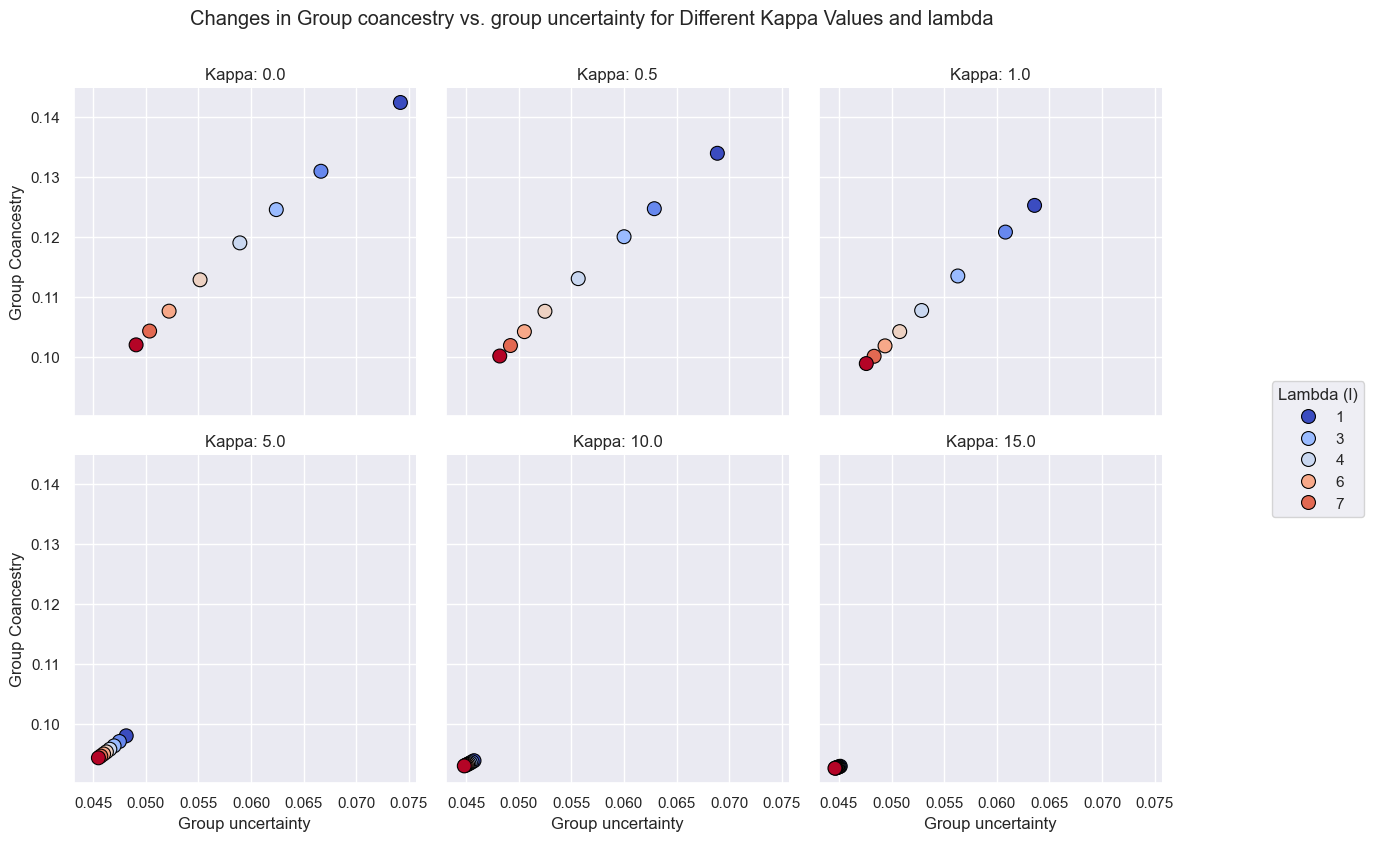

In [29]:
# Define color palette for lambda (l)
palette = sns.color_palette("coolwarm", as_cmap=True)

# Create FacetGrid (wrap plot) for different kappa (k) values
g = sns.FacetGrid(df_selected, col="k", col_wrap=3, height=4, sharey=True, sharex=True)

# Map scatter plot for each kappa
g.map_dataframe(sns.scatterplot, y="z", x="group_coancestry_sel", hue="l", palette="coolwarm", s=100, edgecolor="black")

# Adjust labels and title
g.set_axis_labels("Group uncertainty", "Group Coancestry")
g.set_titles("Kappa: {col_name}")

# Add a common legend for lambda (l)
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, title="Lambda (l)", loc="center right", bbox_to_anchor=(1.15, 0.5))

# Add a main title
plt.suptitle("Changes in Group coancestry vs. group uncertainty for Different Kappa Values and lambda", y=1.05)

# Show plot
plt.show()

In [8]:
correlation_matrix = df_kappa.corr(method='pearson')  # Options: 'pearson', 'spearman', 'kendall'
print(correlation_matrix)

                         kappa  lambda  objective         z  \
kappa                 1.000000     NaN  -0.999533 -0.990903   
lambda                     NaN     NaN        NaN       NaN   
objective            -0.999533     NaN   1.000000  0.994037   
z                    -0.990903     NaN   0.994037  1.000000   
genetic_merit_sel    -0.993491     NaN   0.990705  0.980942   
group_coancestry_sel -0.987446     NaN   0.991346  0.999677   
group_uncertainty    -0.990903     NaN   0.994037  1.000000   
deltaC               -0.987446     NaN   0.991346  0.999677   
Ne                    0.992390     NaN  -0.989389 -0.979208   

                      genetic_merit_sel  group_coancestry_sel  \
kappa                         -0.993491             -0.987446   
lambda                              NaN                   NaN   
objective                      0.990705              0.991346   
z                              0.980942              0.999677   
genetic_merit_sel              1.000000     

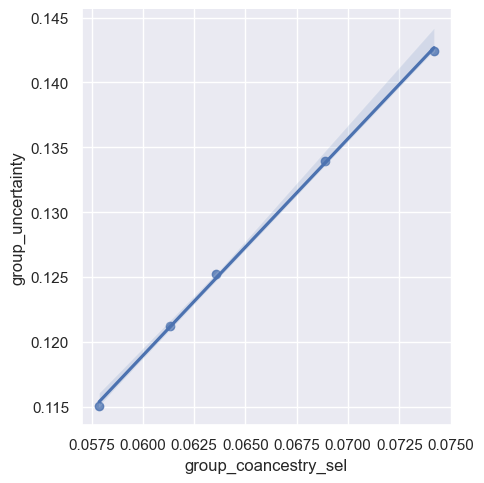

In [10]:
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(y="group_uncertainty", x="group_coancestry_sel", data=df_kappa)
plt.show()

In [8]:
sires_kappa = df_contributions.iloc[sires, ]

print(sires_kappa)

          kappa0      kappa0.5        kappa1      kappa1.5        kappa2
0   4.072974e-19  1.431798e-18  1.560899e-20 -1.254975e-19  1.613863e-20
2   1.470204e-01  1.272875e-01  1.086120e-01  9.810524e-02  8.721424e-02
4   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
6   0.000000e+00  0.000000e+00 -2.488604e-19 -1.079301e-18  5.209512e-03
8   0.000000e+00  0.000000e+00 -2.096475e-19 -4.078415e-19  6.610661e-03
10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
12  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
14  1.172728e-01  1.168203e-01  1.060790e-01  9.956656e-02  9.096713e-02
16  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
18  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
20  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
22  0.000000e+00  0.000000e+00 -2.063079e-18  0.000000e+00  9.540420e-03
24  0.000000e+00  3.150072e-02  4.441153e-02  4.937

In [ ]:
round(sires_kappa.corr(),2)

,kappa0,kappa0.5,kappa1,kappa1.5,kappa2
kappa0,1.00,0.98,0.95,0.91,0.89
kappa0.5,0.98,1.00,0.99,0.96,0.94
kappa1,0.95,0.99,1.00,0.99,0.98
kappa1.5,0.91,0.96,0.99,1.00,1.00
kappa2,0.89,0.94,0.98,1.00,1.00


From the table above we can see a positve and high correlation among the values of kappa used. 
Similar solution high correlation, but we cleraly that individual males are given positive contributions when we increase kappa

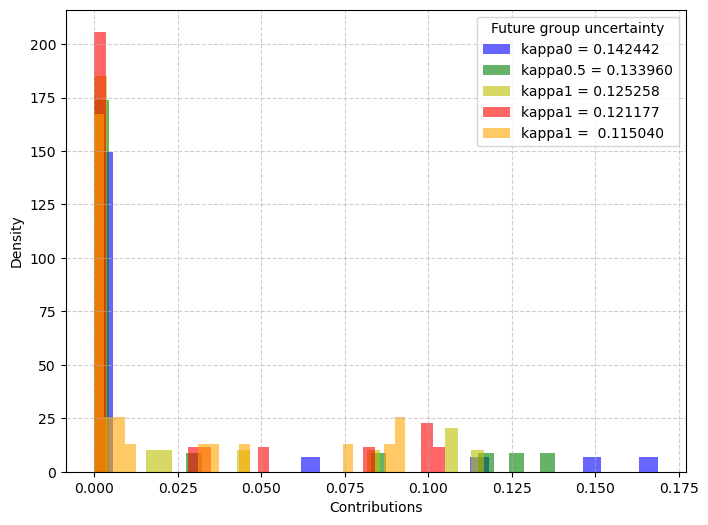

In [21]:
plt.figure(figsize=(8, 6))

# Plot histograms with labels
plt.hist(sires_kappa['kappa0'], density=True, bins=30, alpha=0.6, color='b', label=f'kappa0 = 0.142442')
plt.hist(sires_kappa['kappa0.5'], density=True, bins=30, alpha=0.6, color='g', label=f'kappa0.5 = 0.133960')
plt.hist(sires_kappa['kappa1'], density=True, bins=30, alpha=0.6, color='y', label=f'kappa1 = 0.125258')
plt.hist(sires_kappa['kappa1.5'], density=True, bins=30, alpha=0.6, color='r', label=f'kappa1 = 0.121177')
plt.hist(sires_kappa['kappa2'], density=True, bins=30, alpha=0.6, color='orange', label=f'kappa1 =  0.115040')



# Labels and title
plt.xlabel("Contributions")
plt.ylabel("Density")
# Add legend with a title
plt.legend(loc='upper right', title="Future group uncertainty")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Shinkage property of blup

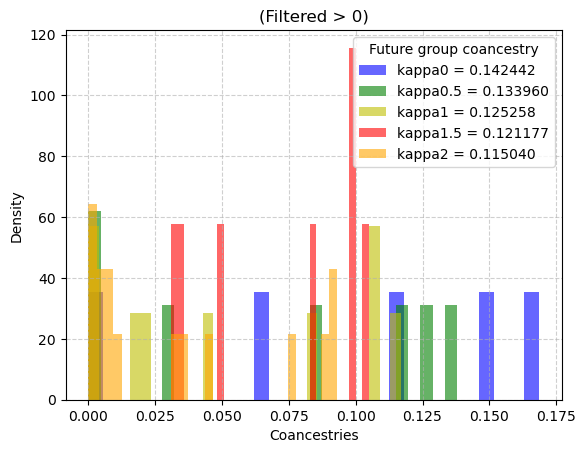

In [33]:
# Filter values greater than 0 for each dataset
kappa0_filtered = sires_kappa['kappa0'][sires_kappa['kappa0'] > 0]
kappa0_5_filtered = sires_kappa['kappa0.5'][sires_kappa['kappa0.5'] > 0]
kappa1_filtered = sires_kappa['kappa1'][sires_kappa['kappa1'] > 0]
kappa1_5_filtered = sires_kappa['kappa1.5'][sires_kappa['kappa1.5'] > 0]
kappa2_filtered = sires_kappa['kappa2'][sires_kappa['kappa2'] > 0]

# Plot histograms with filtered data
plt.hist(kappa0_filtered, density=True, bins=30, alpha=0.6, color='b', label=f'kappa0 = 0.142442')
plt.hist(kappa0_5_filtered, density=True, bins=30, alpha=0.6, color='g', label=f'kappa0.5 = 0.133960')
plt.hist(kappa1_filtered, density=True, bins=30, alpha=0.6, color='y', label=f'kappa1 = 0.125258')
plt.hist(kappa1_5_filtered, density=True, bins=30, alpha=0.6, color='r', label=f'kappa1.5 = 0.121177')
plt.hist(kappa2_filtered, density=True, bins=30, alpha=0.6, color='orange', label=f'kappa2 = 0.115040')


# Labels and title
plt.xlabel("Coancestries")
plt.ylabel("Density")
plt.title("(Filtered > 0)")

# Add legend with a title
plt.legend(loc='upper right', title="Future group coancestry")

plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

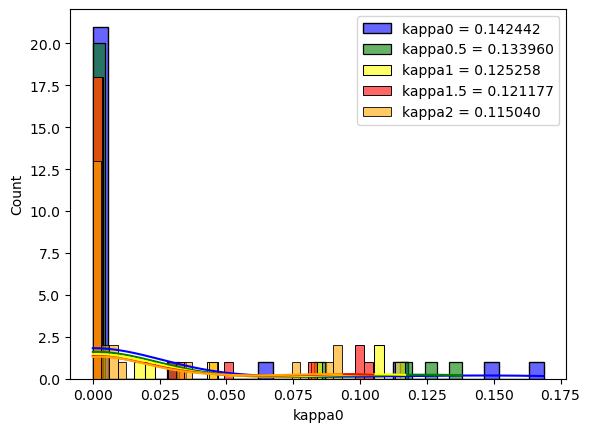

In [32]:
sns.histplot(sires_kappa['kappa0'], kde=True, bins=30, color='blue', label=f'kappa0 = 0.142442', alpha=0.6)
sns.histplot(sires_kappa['kappa0.5'], kde=True, bins=30, color='green', label=f'kappa0.5 = 0.133960', alpha=0.6)
sns.histplot(sires_kappa['kappa1'], kde=True, bins=30, color='yellow', label=f'kappa1 = 0.125258', alpha=0.6)
sns.histplot(sires_kappa['kappa1.5'], kde=True, bins=30, color='red', label=f'kappa1.5 = 0.121177', alpha=0.6)
sns.histplot(sires_kappa['kappa2'], kde=True, bins=30, color='orange', label=f'kappa2 = 0.115040', alpha=0.6)

plt.legend()
plt.show()

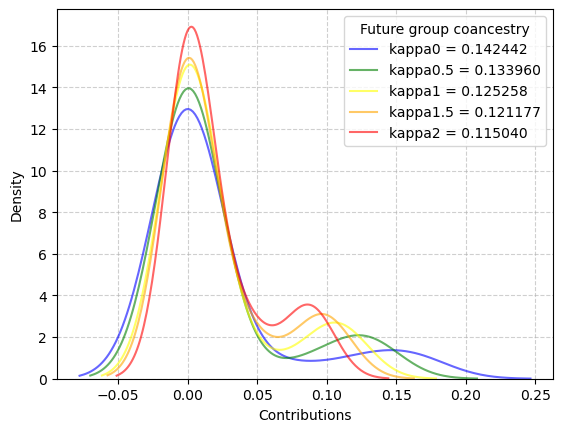

In [12]:
sns.kdeplot(sires_kappa['kappa0'], color='blue', label=f'kappa0 = 0.142442', fill=False, alpha=0.6)
sns.kdeplot(sires_kappa['kappa0.5'], color='green', label=f'kappa0.5 = 0.133960', fill=False, alpha=0.6)
sns.kdeplot(sires_kappa['kappa1'], color='yellow', label=f'kappa1 = 0.125258', fill=False, alpha=0.6)
sns.kdeplot(sires_kappa['kappa1.5'], color='orange', label=f'kappa1.5 = 0.121177', fill=False, alpha=0.6)
sns.kdeplot(sires_kappa['kappa2'], color='red', label=f'kappa2 = 0.115040', fill=False, alpha=0.6)

# Labels and title
plt.xlabel("Contributions")
plt.ylabel("Density")

# Add legend with a title
plt.legend(loc='upper right', title="Future group coancestry")

# Grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()

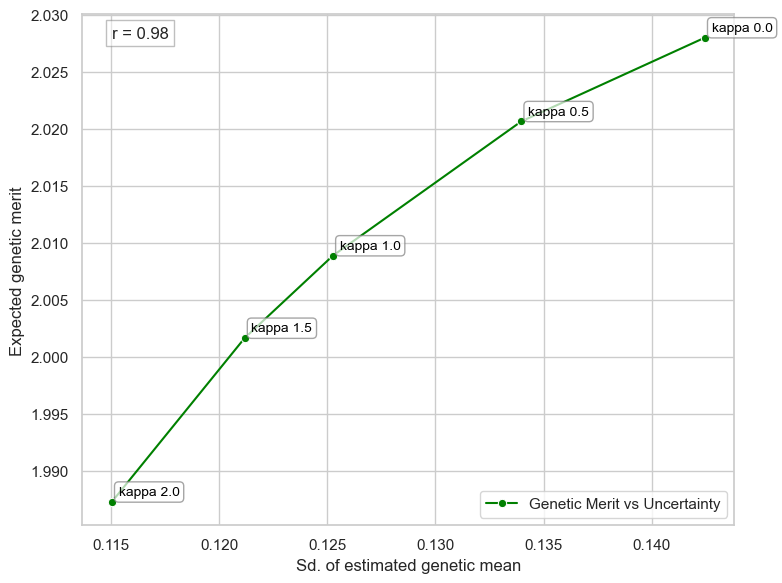

In [13]:

# Set a Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Compute Pearson correlation
corr, _ = stats.pearsonr(df_kappa['group_uncertainty'], df_kappa['geneticMeritSel'])

# Create a figure for plotting
plt.figure(figsize=(8, 6))

# Use Seaborn lineplot for better visuals
ax = sns.lineplot(data=df_kappa, x='group_uncertainty', y='geneticMeritSel', marker='o', color='green')

# Add labels and title with improved styling
plt.xlabel('Sd. of estimated genetic mean', fontsize=12)
plt.ylabel('Expected genetic merit', fontsize=12)

# Show legend
plt.legend(["Genetic Merit vs Uncertainty"], loc='lower right')

# Annotate correlation on the plot
plt.text(
    x=df_kappa['group_uncertainty'].min(),
    y=df_kappa['geneticMeritSel'].max(),
    s=f'r = {corr:.2f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray')
)

# Add labels to each point from the 'kappa' column
for i, row in df_kappa.iterrows():
    plt.annotate(
        f"kappa {row['kappa']}",  # Label comes from 'kappa' column
        (row['group_uncertainty'], row['geneticMeritSel']),  # Position on plot
        textcoords="offset points",
        xytext=(5, 5),  # Offset for better readability
        ha='left',
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle="round,pad=0.3")  # Background box for clarity
    )

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

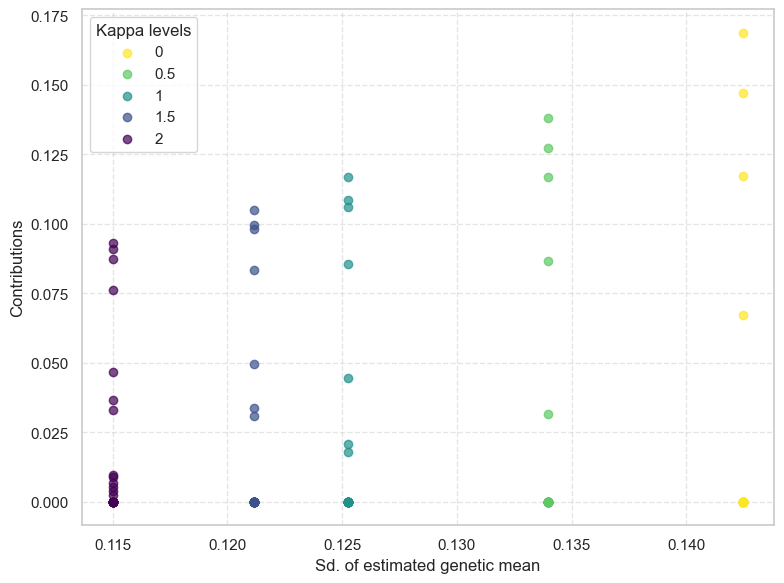

In [ ]:
# uncertainty vs contributions

df_contributions['mubar'] = mubar
#print(df_contributions)

# Filter to keep just sires 
kappa_sires = df_contributions.iloc[range(0, n, 2)]
#print(kappa_sires)

# Define the Kappa levels
kappa_gu = [0.142442, 0.133960, 0.125258, 0.121177, 0.115040]
kappa_levels = ["0", "0.5", "1", "1.5", "2"]

# Sort kappa_levels to maintain order
sorted_kappa_levels = sorted(kappa_levels, reverse=True)

# Assign unique colors to kappa levels
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_kappa_levels)))
color_map = {kappa: color for kappa, color in zip(sorted_kappa_levels, colors)}

# Create figure
plt.figure(figsize=(8, 6))

# Dictionary to store legend handles
legend_handles = {}

# Scatter plot loop
for i, kappa in enumerate(kappa_gu):
    j = kappa_levels[i]  # Ensure correct kappa level mapping
    
    scatter = plt.scatter(
        [kappa] * len(kappa_sires),
        kappa_sires.iloc[:, i],  # **Preserving original trend**
        color=color_map[j],  # Use correct colors from kappa_levels
        alpha=0.7
    )
    
    # Store scatter handle for legend (only first occurrence)
    if j not in legend_handles:
        legend_handles[j] = scatter

# Create legend with correct colors
plt.legend(handles=legend_handles.values(), labels=legend_handles.keys(), loc='upper left', title="Kappa levels")

# Labels and title
plt.xlabel('Sd. of estimated genetic mean', fontsize=12)
plt.ylabel("Contributions", fontsize=12)
#plt.title("Future group coancestry vs Contributions")



# Grid and layout
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()

Relationship between contributions(y-axis) to kappa (x-axis)

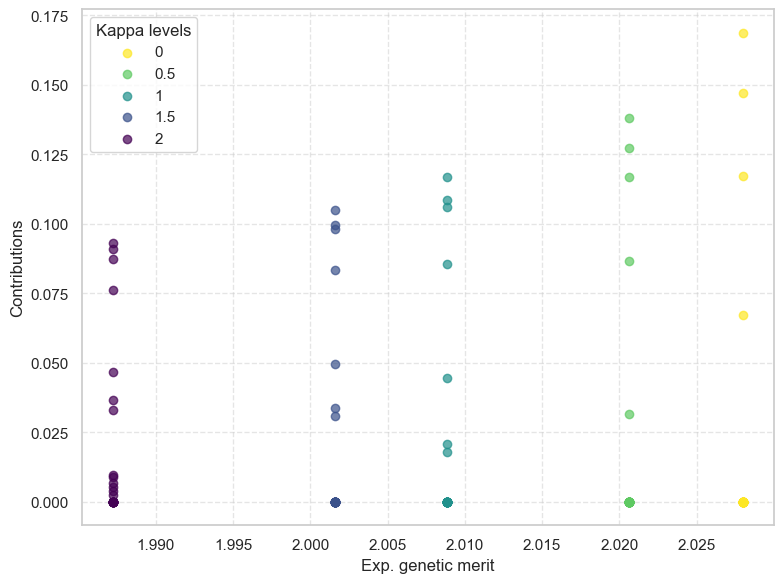

In [17]:
# uncertainty vs contributions

#df_contributions['mubar'] = mubar
#print(df_contributions)

# Filter to keep just sires 
#kappa_sires = df_contributions.iloc[range(0, n, 2)]
#print(kappa_sires)

# Define the Kappa levels
kappa_merit = [2.027965, 2.020623, 2.008856 , 2.001628, 1.987270]
kappa_levels = ["0", "0.5", "1", "1.5", "2"]


# Sort kappa_levels to maintain order
sorted_kappa_levels = sorted(kappa_levels, reverse=True)

# Assign unique colors to kappa levels
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_kappa_levels)))
color_map = {kappa: color for kappa, color in zip(sorted_kappa_levels, colors)}

# Create figure
plt.figure(figsize=(8, 6))

# Dictionary to store legend handles
legend_handles = {}

# Scatter plot loop
for i, kappa in enumerate(kappa_merit):
    j = kappa_levels[i]  # Ensure correct kappa level mapping
    
    scatter = plt.scatter(
        [kappa] * len(kappa_sires),
        kappa_sires.iloc[:, i],  # **Preserving original trend**
        color=color_map[j],  # Use correct colors from kappa_levels
        alpha=0.7
    )
    
    # Store scatter handle for legend (only first occurrence)
    if j not in legend_handles:
        legend_handles[j] = scatter

# Create legend with correct colors
plt.legend(handles=legend_handles.values(), labels=legend_handles.keys(), loc='upper left', title="Kappa levels")

# Labels and title
plt.xlabel('Exp. genetic merit', fontsize=12)
plt.ylabel("Contributions", fontsize=12)
#plt.title("Future group coancestry vs Contributions")



# Grid and layout
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()

/var/folders/yh/0bk27b457hb862b_2wsrctcr0000gr/T/ipykernel_1723/358015326.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kappa_sires[col] for col in kappa_columns], labels=kappa_columns)


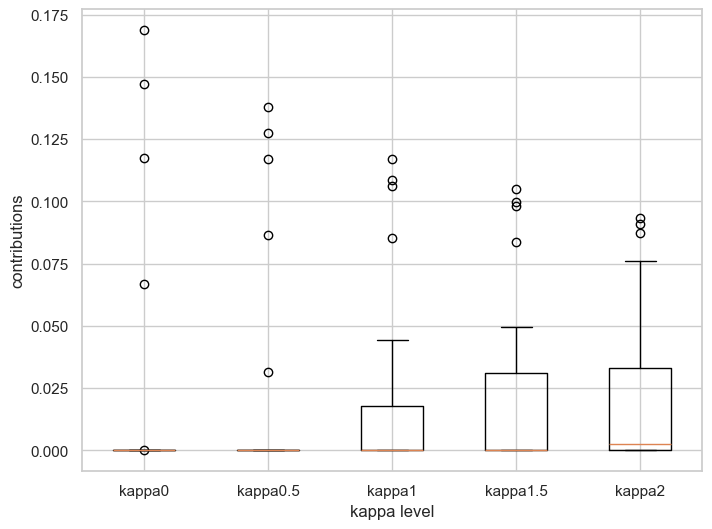

In [25]:

# Select only the Kappa columns
kappa_columns = ["kappa0", "kappa0.5", "kappa1", "kappa1.5", "kappa2"]
# Standardize by dividing by the max value of each column
#kappa_standardized = kappa_values / kappa_values.max()

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([kappa_sires[col] for col in kappa_columns], labels=kappa_columns)

# Labels and title
plt.xlabel("kappa level")
plt.ylabel("contributions")
#plt.title("Boxplot of Kappa Values vs contributions")

# Show the plot
plt.show()

In [46]:
df_contributions['ebv'] = mubar
# Assuming omega is a list of 2D sparse matrices
#diagonals = [omega[k].diagonal() for k in range(len(omega))]

# Convert to DataFrame column
df_contributions['diag_omega'] = omega.diagonal()

print(df_contributions)

          kappa0      kappa0.5        kappa1      kappa1.5        kappa2  \
0   4.072974e-19  1.431798e-18  1.560899e-20 -1.254975e-19  1.613863e-20   
1   2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02   
2   1.470204e-01  1.272875e-01  1.086120e-01  9.810524e-02  8.721424e-02   
3   2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02   
4   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
5   2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02   
6   0.000000e+00  0.000000e+00 -2.488604e-19 -1.079301e-18  5.209512e-03   
7   2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02   
8   0.000000e+00  0.000000e+00 -2.096475e-19 -4.078415e-19  6.610661e-03   
9   2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02   
10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
11  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02  2.000000e-02   
12  0.000000

In [45]:
print(omega.diagonal())

[0.23750695 0.23403376 0.24225153 0.23392401 0.24376174 0.21594387
 0.24408171 0.23927029 0.22921629 0.22991034 0.23669059 0.22666118
 0.23341338 0.22075913 0.22560526 0.23202369 0.22253131 0.22451434
 0.23260468 0.22635197 0.22766508 0.21153899 0.23573646 0.21727198
 0.23944681 0.22934081 0.21611654 0.23621635 0.24272089 0.21956236
 0.22935589 0.23722826 0.22489723 0.23192813 0.22574469 0.22118344
 0.23007929 0.22436653 0.2206412  0.23059497 0.2459532  0.22169469
 0.22901781 0.21072855 0.23692669 0.22563814 0.22850344 0.22177001
 0.21422955 0.22658852]


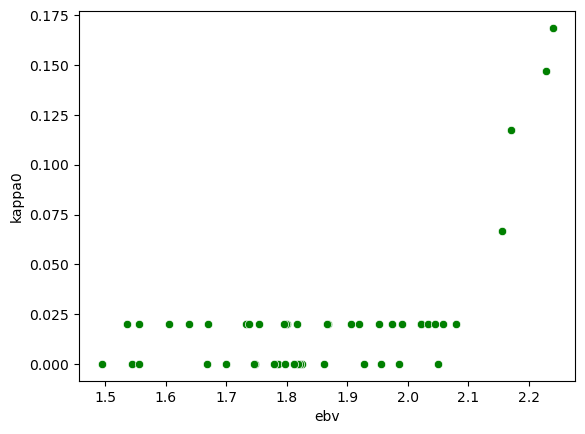

In [32]:
# Use Seaborn lineplot for better visuals
ax1 = sns.scatterplot(data=df_contributions, y="kappa0" , x='ebv', marker='o', color='green')
#ax3 = sns.lineplot(data=df_contributions, y="kappa1" , x='ebv', marker='o', color='orange')
#ax2 = sns.lineplot(data=df_contributions, y="kappa0.5" , x='ebv', marker='o', color='r')
#ax4 = sns.lineplot(data=df_contributions, y="kappa1.5" , x='ebv', marker='o', color='blue')
#ax5 = sns.lineplot(data=df_contributions, y="kappa2" , x='ebv', marker='o', color='yellow')

#plt.show(ax1)
#plt.show(ax2)
#plt.show(ax3)
#plt.show(ax4)
#plt.show(ax5)

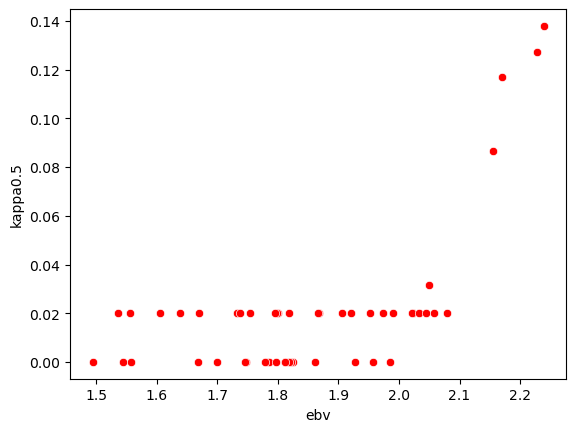

In [33]:
ax2 = sns.scatterplot(data=df_contributions, y="kappa0.5" , x='ebv', marker='o', color='r')

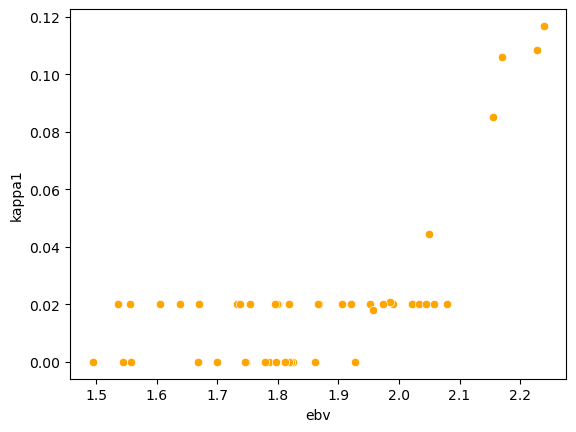

In [34]:
ax3 = sns.scatterplot(data=df_contributions, y="kappa1" , x='ebv', marker='o', color='orange')

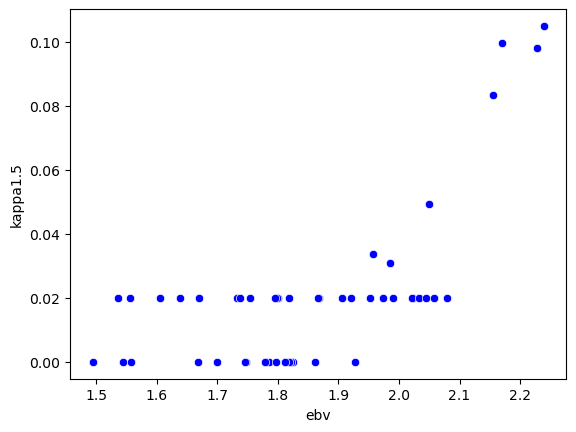

In [35]:
ax4 = sns.scatterplot(data=df_contributions, y="kappa1.5" , x='ebv', marker='o', color='blue')


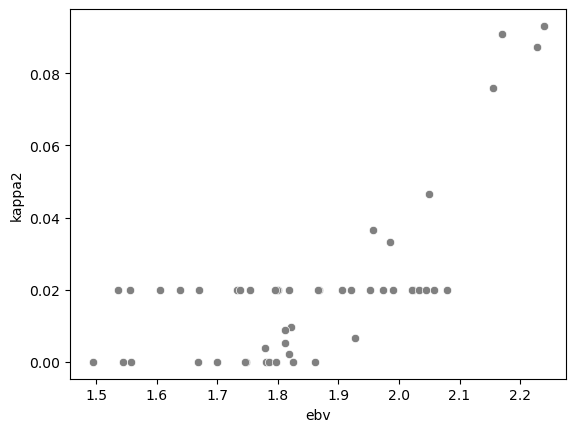

In [37]:
ax5 = sns.scatterplot(data=df_contributions, y="kappa2" , x='ebv', marker='o', color='grey')


as we increasing the kappa animals with highr ebv tend to be less contributions

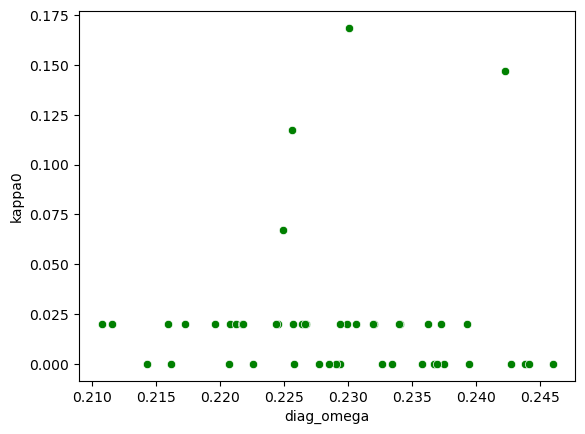

In [47]:
# Omega diag
ax1 = sns.scatterplot(data=df_contributions, y="kappa0" , x='diag_omega', marker='o', color='green')


Diagonal variance of EBV, how much uncertainty, 

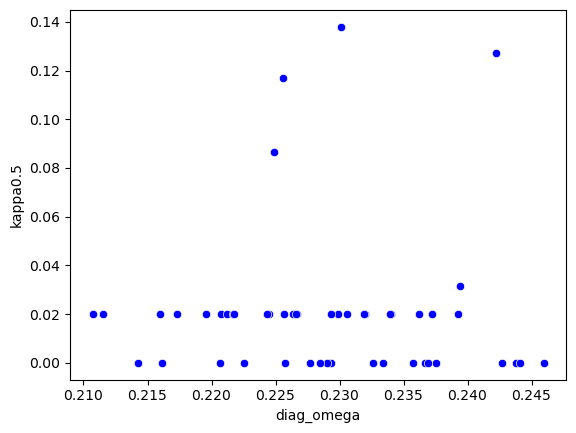

In [49]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa0.5" , x='diag_omega', marker='o', color='blue')


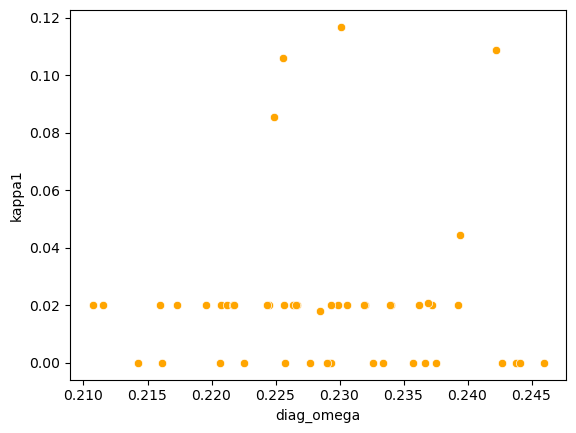

In [50]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa1" , x='diag_omega', marker='o', color='orange')


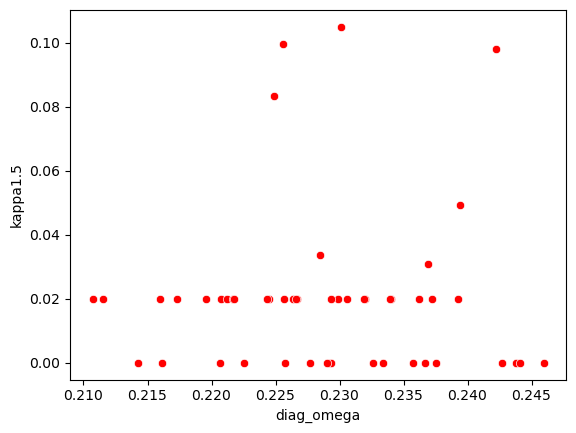

In [51]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa1.5" , x='diag_omega', marker='o', color='r')


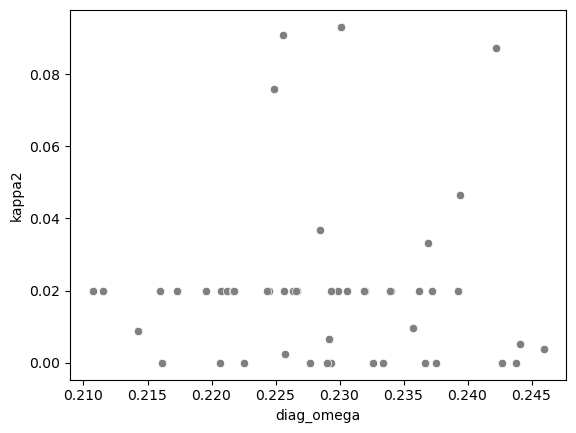

In [52]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa2" , x='diag_omega', marker='o', color='grey')


In [56]:
ones = np.ones(n)
#print(ones)
#print(ones.shape)

#print(ones@omega) # sum each male

df_contributions["sum_omega"] = ones@omega

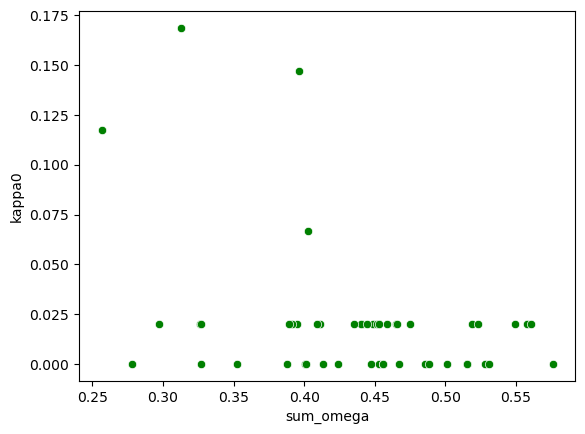

In [57]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa0" , x='sum_omega', marker='o', color='green')

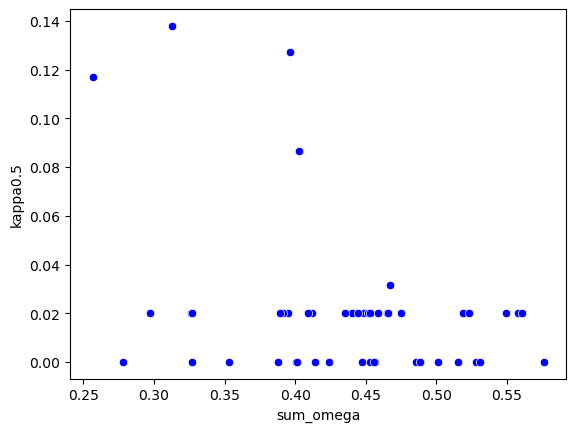

In [58]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa0.5" , x='sum_omega', marker='o', color='blue')

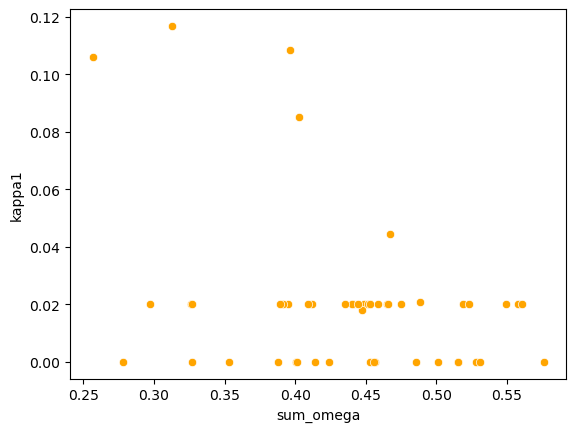

In [59]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa1" , x='sum_omega', marker='o', color='orange')

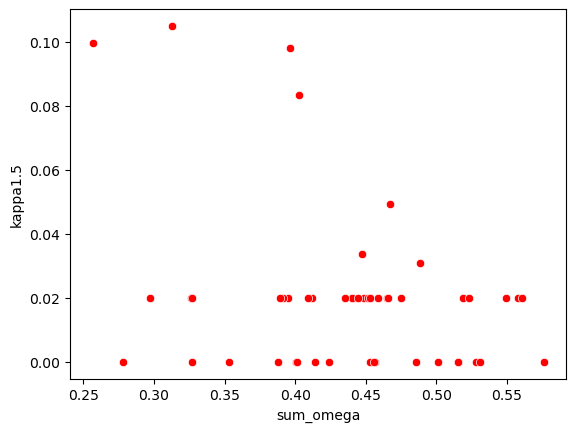

In [60]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa1.5" , x='sum_omega', marker='o', color='r')

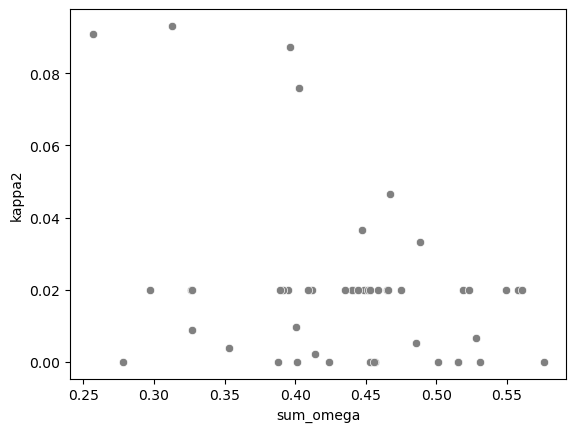

In [61]:
ax1 = sns.scatterplot(data=df_contributions, y="kappa2" , x='sum_omega', marker='o', color='grey')

<Axes: xlabel='sum_omega', ylabel='kappa2'>

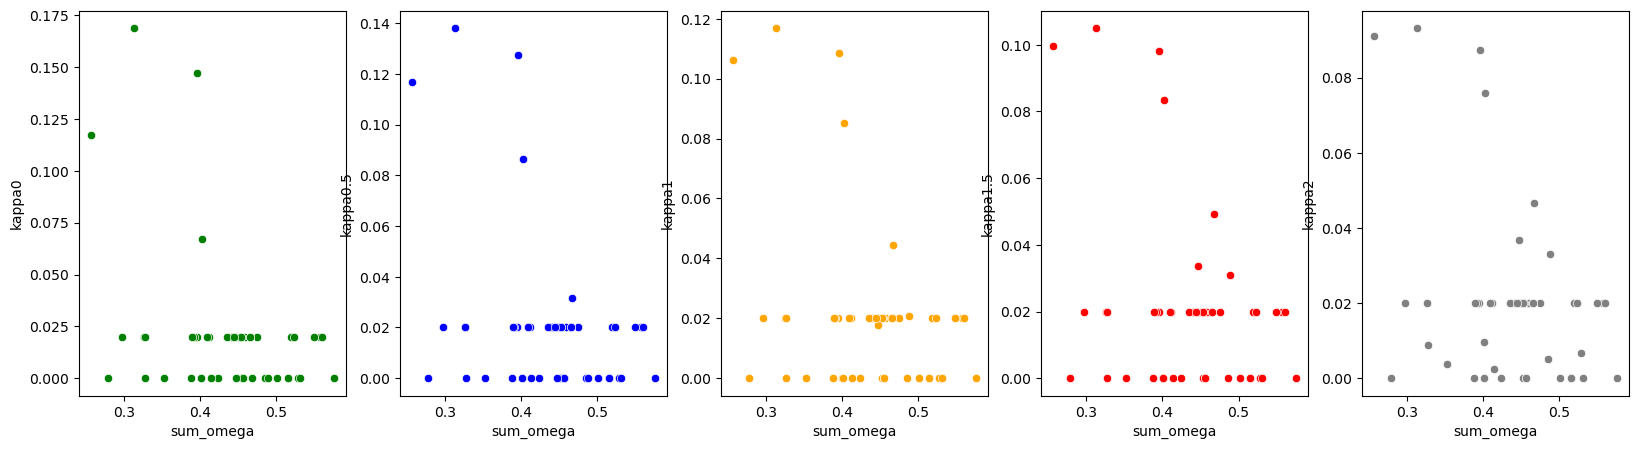

In [68]:
# Create the figure and axes
fig, axs = plt.subplots(ncols=5, figsize=(20, 5))  # Adjust figure size as needed

# Plot each scatter plot in its respective subplot
sns.scatterplot(data=df_contributions, y="kappa0", x='sum_omega', marker='o', color='green', ax=axs[0])
sns.scatterplot(data=df_contributions, y="kappa0.5", x='sum_omega', marker='o', color='blue', ax=axs[1])
sns.scatterplot(data=df_contributions, y="kappa1", x='sum_omega', marker='o', color='orange', ax=axs[2])
sns.scatterplot(data=df_contributions, y="kappa1.5", x='sum_omega', marker='o', color='red', ax=axs[3])
sns.scatterplot(data=df_contributions, y="kappa2", x='sum_omega', marker='o', color='grey', ax=axs[4])

- Fix the scale
- they seem to spread a bit to the right
- Indivual variance and covariance with everybody else
- Talk 

Description: The boxplot displays the Kappa values (0, 0.5, and 1) on the x-axis against contributions on the y-axis. As the value of lambda increases, fewer bulls are selected as future parents, which explains the decreasing variation observed across the three scenarios. 

In [ ]:
# Define kappa and lambda values
values_kappa = [0.0, 0.5, 1.0, 1.5, 2.0]
values_lambda = [1, 2, 2.3, 3, 4, 4.5, 5, 5.4, 5.5, 5.6, 5.7, 6, 7, 8, 8.6, 8.7, 8.8, 9, 10, 11, 12, 13, 14, 15]

# Initialize lists to store results
results = []
contributions = []

# Get dimensions from kinship matrix
n = sigma.shape[0]

# Upper and Lower Bounds
upper = np.zeros(n)
upper[::2] = 0.5  
upper[1::2] = 0.02 

lower = np.zeros(n)
lower[::2] = 0.0  
lower[1::2] = 0.02  

# Compute kinship factor
kin = sigma / 2

# Initialize equal selection weights
w = np.ones(n) / n

# Compute current genetic merit and coancestry
genetic_merit_sel = utils.expected_genetic_merit(w, mubar)
group_coancestry_sel = utils.group_coancestry(w, kin)
group_uncertainty = math.sqrt(w.transpose()@omega@w)
deltaC = (group_coancestry_sel - group_coancestry_current) / (1.0 - group_coancestry_current)
Ne = 1 / (2 * deltaC)

# Loop over all kappa and lambda values
for k in values_kappa:
    for l in values_lambda:
        # Run the optimization function for each (kappa, lambda) combination
        w, z, obj = rocs.highs_robust_genetics(sigma, mubar, omega, sires, dams, lam=l, kappa=k, dimension=n, upper_bound=upper, lower_bound=lower)
        
        # Compute genetic merit and coancestry after selection
        genetic_merit_sel = utils.expected_genetic_merit(w, mubar)
        group_coancestry_sel = utils.group_coancestry(w, kin)

        # Compute changes in coancestry and effective population size (Ne)
        deltaC = (group_coancestry_sel - group_coancestry_current) / (1.0 - group_coancestry_current)
        Ne = 1 / (2 * deltaC) if deltaC != 0 else np.inf  # Avoid division by zero

        # Store results
        results.append((k, l, obj, z, genetic_merit_sel, group_coancestry_sel, deltaC, Ne))
        contributions.append(w)

# Convert results into a DataFrame for easy analysis
df_kappa = pd.DataFrame(results, columns=['k', 'l', 'obj', 'z', 'genetic_merit_sel', 'group_coancestry_sel', 'deltaC', 'Ne'])

/var/folders/yh/0bk27b457hb862b_2wsrctcr0000gr/T/ipykernel_5362/3996186335.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  Ne = 1 / (2 * deltaC)


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Running Hi

0.005

In [43]:
print(df_kappa)

       k     l       obj         z  genetic_merit_sel  group_coancestry_sel  \
0    0.0   1.0  1.953775  0.142442           2.027965              0.074190   
1    0.0   2.0  1.883238  0.130960           2.016518              0.066640   
2    0.0   2.3  1.863509  0.128650           2.013004              0.064998   
3    0.0   3.0  1.818947  0.124556           2.006142              0.062398   
4    0.0   4.0  1.758040  0.119002           1.993785              0.058936   
..   ...   ...       ...       ...                ...                   ...   
115  2.0  11.0  1.209915  0.095519           1.904332              0.045762   
116  2.0  12.0  1.164285  0.095150           1.900713              0.045511   
117  2.0  13.0  1.118884  0.094849           1.897447              0.045297   
118  2.0  14.0  1.073683  0.094581           1.894367              0.045109   
119  2.0  15.0  1.028662  0.094353           1.891504              0.044942   

       deltaC          Ne  
0    0.031868   15.6899

In [44]:
# print(1/(2*50)) # Rate of inbreeding when Ne = 50 (0.01)
# print(1/(2*100)) # Rate of inbreeding when Ne = 100 (0.005)

# Select the required columns
df_selected = df_kappa[['Ne', 'k', 'l', 'obj', 'z', 'genetic_merit_sel', 'group_coancestry_sel', 'deltaC']]

# Round the values to 2 decimal places
df_rounded = df_selected.round(4)

# Print using tabulate
print(tabulate(df_rounded, headers='keys', tablefmt='psql'))

+-----+----------+-----+------+--------+--------+---------------------+------------------------+----------+
|     |       Ne |   k |    l |    obj |      z |   genetic_merit_sel |   group_coancestry_sel |   deltaC |
|-----+----------+-----+------+--------+--------+---------------------+------------------------+----------|
|   0 |  15.69   | 0   |  1   | 1.9538 | 0.1424 |              2.028  |                 0.0742 |   0.0319 |
|   1 |  20.8576 | 0   |  2   | 1.8832 | 0.131  |              2.0165 |                 0.0666 |   0.024  |
|   2 |  22.4673 | 0   |  2.3 | 1.8635 | 0.1287 |              2.013  |                 0.065  |   0.0223 |
|   3 |  25.5933 | 0   |  3   | 1.8189 | 0.1246 |              2.0061 |                 0.0624 |   0.0195 |
|   4 |  31.415  | 0   |  4   | 1.758  | 0.119  |              1.9938 |                 0.0589 |   0.0159 |
|   5 |  36.1829 | 0   |  4.5 | 1.7291 | 0.1158 |              1.9853 |                 0.0569 |   0.0138 |
|   6 |  41.7961 | 0   |  5 